In [1]:
#https://modelo.covid19.cdmx.gob.mx/modelo-epidemico
#https://github.com/ollin18/ComplexSystems.jl/blob/master/examples/CDMX_model.ipynb

import numpy as np
import matplotlib.pyplot as plt

VARS = ['susceptibles', 'infecciosos', 'expuestos', 'leve', 'grave', 'hospitalizados', 'uci', 'recuperados', 'muertos']

#por qué necesita esta distribucion?
def degree_dist(p, k_max):
    pk = np.zeros(k_max)
    #print(pk)
    for k in range(k_max-1):
        pk[k+1] = (1 - np.exp(-p)) * np.exp(-p * k)
    #print(pk)
    return pk

#Genera una matriz con los casos a probar (simulaciones?)
#[sus1 sus2 ... inf1 inf2 ... exp1 exp2 ... leve1 ... leve2 ...]
#inicia solo con susceptibles e infectados, lo demás en cero
def make_proportions(compart_num, init_infec):
    susceptible = 1 - prop_inf
    initial = np.array([susceptible, init_infec])
    for n in range(compart_num-2):
        initial = np.vstack((initial, np.zeros(len(init_infec))))
    return initial.flatten()

In [2]:
def CDMX(x, t, k_max, prop_deg):
    def iof(ind):
        n = VARS.index(ind)
        return x[(n * k_max):((n+1) * k_max)]    

    #Nombres en el modelo de CDMX (2020-05-14)
    R0=2.83         #Tasa de reproducción estimada
    Dinf=2.9        #Tiempo que es infeccioso el paciente
    Dincub=5.2      #Tiempo incubación
    Drl=14          #Tiempo recuperación casos intermedios
    Dhosp=4         #Días entre síntomas y hospitalización
    Drh=12          #Días totales de hospitalización
    Duci=1          #**No especificado en modelo: Dias en UCI
    Druci=7 #10    #**No especificado en modelo: Dias de recuperacion de UCI
    Dm=8            #**No especificado en modelo: Dias a muerte en UCI
    pgrav=0.138     #Tasa de hospitalización
    puci=0.05       #Tasa de UCI
    pm=0.030        #Tasa de mortalidad
    #Otros:
    #  Tiempo entre incubación y muerte [dias]: 32 
    #  Poblacion susceptible [millones]: 22 (ver en código)
    
    y = np.zeros(len(x))
    k_mult = np.arange(1, k_max+1) * prop_deg
    avg_k = np.sum(k_mult)
    further = np.sum(np.multiply(k_mult, iof('expuestos')))
    th = further / avg_k
    
    for k in range(k_max):
        d_sus = -(R0/Dinf) * iof('infecciosos')[k] * iof('susceptibles')[k]
        d_exp = (R0/Dinf) * iof('infecciosos')[k] * iof('susceptibles')[k] - (1/Dincub)*iof('expuestos')[k]
        d_inf = (1/Dincub) * iof('expuestos')[k] - (1/Dinf) * iof('infecciosos')[k]
        d_leve = (1-pgrav) * (1/Dinf) * iof('infecciosos')[k] - (1/Drl) * iof('leve')[k]
        d_grav = pgrav * (1/Dinf) * iof('infecciosos')[k] - (1/Dhosp) * iof('grave')[k]
        d_hosp = (1/Dhosp) * iof('grave')[k] - (1-puci) * (1/Drh) * iof('hospitalizados')[k] \
            - puci * (1/Duci)*iof('hospitalizados')[k]
        d_uci = puci * (1/Duci) * iof('hospitalizados')[k] - (1-pm) * (1/Druci) * iof('uci')[k] \
            - pm * (1/Dm) * iof('uci')[k]
        d_rec = (1/Drl) * iof('leve')[k] + (1-puci) * (1/Drh) * iof('hospitalizados')[k] \
            + (1-pm) * (1/Druci) * iof('uci')[k]
        d_mue = pm * (1/Dm) * iof('uci')[k]

        y[k] = d_sus
        y[k_max + k] = d_inf
        y[2*k_max + k] = d_exp
        y[3*k_max + k] = d_leve
        y[4*k_max + k] = d_grav
        y[5*k_max + k] = d_hosp
        y[6*k_max + k] = d_uci
        y[7*k_max + k] = d_rec
        y[8*k_max + k] = d_mue
            
    return y

In [3]:
#numero de "escenarios"
k_max = 200

p = 0.4
infec = np.random.rand(k_max)
all_infec = sum(infec)
prop_inf = infec / all_infec
prop_inf

array([7.39239758e-03, 5.09136537e-03, 2.94782709e-03, 6.03577022e-03,
       6.19948141e-03, 1.32279704e-03, 2.39020849e-03, 8.16309090e-03,
       3.52334055e-05, 8.58230073e-03, 6.87136498e-03, 7.70094970e-03,
       9.73866277e-04, 4.16468212e-03, 7.24379147e-03, 6.50456677e-03,
       7.98855464e-04, 2.69112469e-03, 6.33132469e-05, 7.09087813e-03,
       2.21849685e-03, 3.80513634e-03, 7.30729429e-03, 7.79889484e-03,
       2.42967758e-03, 5.68644878e-03, 5.91829081e-03, 7.73100076e-03,
       2.24547898e-03, 1.92336644e-03, 4.05299267e-03, 8.57209370e-03,
       3.83091824e-03, 5.26631906e-03, 7.48857987e-03, 8.72644422e-03,
       4.03129707e-03, 7.10882673e-03, 7.26387668e-03, 3.45298983e-03,
       7.28344755e-03, 3.40060768e-03, 6.25051299e-03, 7.43027255e-03,
       4.71017548e-03, 4.37730983e-03, 5.45004821e-03, 6.42441298e-03,
       7.44722977e-03, 2.04255607e-03, 2.15951201e-03, 4.42604897e-03,
       6.96412238e-03, 2.55491400e-03, 4.72698845e-03, 6.96044616e-03,
      

In [4]:
np.sum(prop_inf * np.arange(1, k_max+1))

98.60490298476017

In [5]:
the_proportions = make_proportions(9, prop_inf)
the_proportions
len(the_proportions)

1800

[0.         0.32967995 0.22099108 0.14813475 0.09929769 0.06656123
 0.04461733 0.02990789 0.02004786 0.01343848]


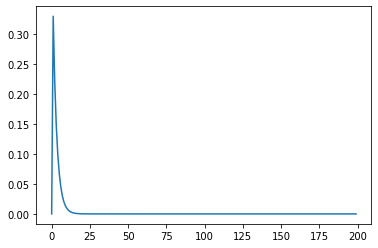

In [6]:
#pd es el parámetro prop_deg del modelo (qué es?)
pd = degree_dist(p, k_max)
print(pd[:10])
#sum(pd)
plt.plot(pd)

In [7]:
np.sum(np.multiply(pd, np.arange(1, k_max+1)))

4.033244781719736

In [8]:
from scipy.integrate import odeint
t = np.arange(0, 101, 1)
y1 = odeint(CDMX, the_proportions, t, args=(k_max, pd))

In [9]:
y1.shape

(101, 1800)

In [10]:
print(y1[0].shape)
y1[0]

(1800,)


array([0.9926076 , 0.99490863, 0.99705217, ..., 0.        , 0.        ,
       0.        ])

In [11]:
susceptibles = [np.sum(np.multiply(ye[:k_max], pd)) for ye in y1]
print(len(susceptibles))
susceptibles

101


[0.9954546561658805,
 0.9916202221429088,
 0.9883721046844923,
 0.9851671328529135,
 0.981697316651493,
 0.9777635907632991,
 0.9732136991551783,
 0.967911315523369,
 0.9617206288712017,
 0.9544988043362362,
 0.9460927467405286,
 0.936338544275854,
 0.9250629913445576,
 0.9120870666056221,
 0.8972314559070106,
 0.880324250791432,
 0.8612108871267063,
 0.8397661431221294,
 0.8159076770204068,
 0.7896101735020779,
 0.7609186984291779,
 0.729959530062784,
 0.6969465115680498,
 0.6621812098871924,
 0.6260457078648178,
 0.5889878010609195,
 0.5514996110960565,
 0.5140916577068309,
 0.4772652748264987,
 0.44148648456720563,
 0.40716406104344455,
 0.37463374584932296,
 0.34414943931433883,
 0.31588122496707605,
 0.2899192496401021,
 0.26628197076945614,
 0.24492719611845556,
 0.22576440589243904,
 0.208667137904074,
 0.19348455787401303,
 0.18005164394377113,
 0.16819770795242694,
 0.1577531700421515,
 0.14855466147115248,
 0.1404486386192806,
 0.13329373201661837,
 0.1269620852642792,
 0.121

In [12]:
res = {}
for index, var in enumerate(VARS):
    fr = k_max * index
    to = k_max * (index+1)
    res[var] = [np.sum(np.multiply(ye[fr:to], pd)) for ye in y1] 

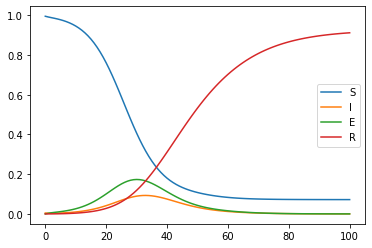

In [13]:
plt.plot(t, res['susceptibles'], label="S")
plt.plot(t, res['infecciosos'], label="I")
plt.plot(t, res['expuestos'], label="E")
#y esto por qué crece?
plt.plot(t, res['recuperados'], label="R")
plt.legend()

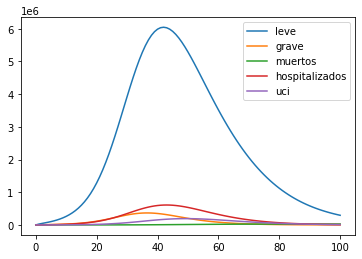

In [14]:
poblacion = 22000000
for var in ['leve', 'grave', 'muertos', 'hospitalizados', 'uci']:
    plt.plot(t, np.multiply(res[var], poblacion), label=var)
plt.legend()

In [15]:
max(res["uci"]) * poblacion

192279.54298831976

In [16]:
max(res["muertos"]) * poblacion

28381.478601351886